In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


# **Loading the dataset**

In [2]:
df =  pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# **To find the number of rows and columns**

In [3]:
df.shape

(2075259, 7)

# **Looking for null values**

In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

**We can see that there are plenty of null values here, we can fill these null values with their mean using the following code cell**

# **Visualization**

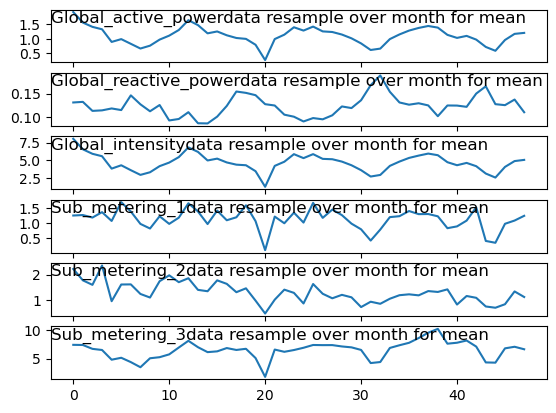

In [5]:
import matplotlib.pyplot as plt

i=1

cols = [0,1,3,4,5,6]

for col in cols:
    plt.subplot(len(cols),1,i)
    plt.plot(df.resample('M').mean().values[:,col])
    plt.title(df.columns[col] + 'data resample over month for mean',y = 0.6,loc = 'left')
    i+=1
plt.show()


**The above plot shows data resample over a month**

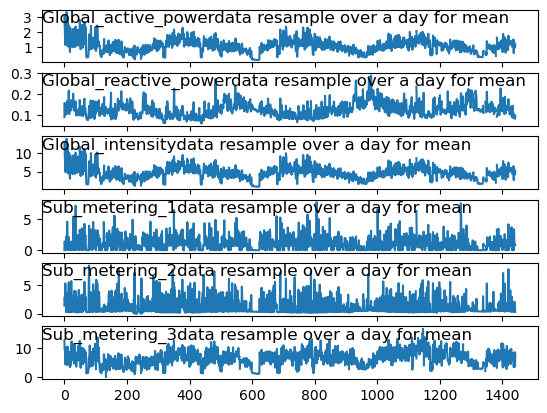

In [6]:
import matplotlib.pyplot as plt

i=1

cols = [0,1,3,4,5,6]

for col in cols:
    plt.subplot(len(cols),1,i)
    plt.plot(df.resample('D').mean().values[:,col])
    plt.title(df.columns[col] + 'data resample over a day for mean',y = 0.6,loc = 'left')
    i+=1
plt.show()


**The above plot shows data resample  over a day for mean**

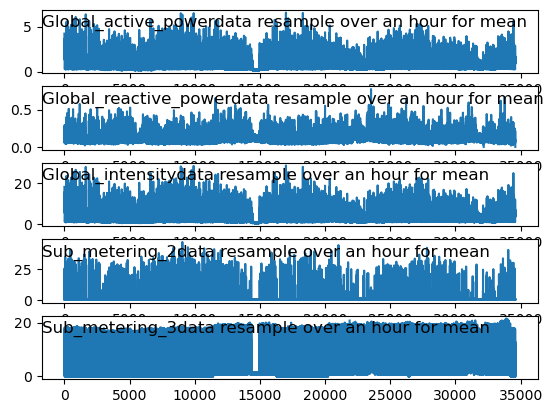

In [7]:
import matplotlib.pyplot as plt

i=1

cols = [0,1,3,5,6]

for col in cols:
    plt.subplot(len(cols),1,i)
    plt.plot(df.resample('H').mean().values[:,col])
    plt.title(df.columns[col] + 'data resample over an hour for mean',y = 0.6,loc = 'left')
    i+=1
plt.show()


**We analyze the data over an hour as it provides a smoother trend which provides better analysis**

# **The LSTM model**

**Preparing the helper function to frame the problem**

In [8]:
df = df[['Global_active_power','Global_reactive_power','Sub_metering_1','Sub_metering_3']]

def series_to_supervised(data,n_in =1,n_out =0,dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols,names = list(),list()
    for i in range(n_in,0,-1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    
    for i in range(0,n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names +=  [('var%d(t-%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols,axis =1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace = True)
        
        return agg
        

**Resampling the data to reduce the calculation time**

In [9]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 4)

# **Preparing the data**

In [10]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
r = list(range(df_resample.shape[1]+1,2*df_resample.shape[1]))
reframed.drop(reframed.columns[r],axis =1,inplace = True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
0,0.545045,0.103358,0.0,0.782676,0.636816
1,0.509006,0.110073,0.0,0.774169,0.545045
2,0.488550,0.096987,0.0,0.778809,0.509006
3,0.455597,0.099010,0.0,0.798917,0.488550
4,0.322555,0.072536,0.0,0.205723,0.455597


**Hence the values are scaled between 0 and 1 using MinMaxScaler**

# **Data Splitting**

In [11]:
values = reframed.values
n_train_time = 4000

train = values[:n_train_time,:]
test = values[n_train_time:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

# **Building the model**

In [12]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100,input_shape = (train_x.shape[1],train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')



# **Network Fitting**

In [13]:
history = model.fit(train_x,train_y,epochs =50,batch_size = 70,validation_data = (test_x,test_y),verbose = 2,shuffle = False)

Epoch 1/50
58/58 - 5s - loss: 0.0327 - val_loss: 0.0123 - 5s/epoch - 78ms/step
Epoch 2/50
58/58 - 1s - loss: 0.0175 - val_loss: 0.0110 - 1s/epoch - 20ms/step
Epoch 3/50
58/58 - 2s - loss: 0.0166 - val_loss: 0.0106 - 2s/epoch - 26ms/step
Epoch 4/50
58/58 - 1s - loss: 0.0155 - val_loss: 0.0103 - 1s/epoch - 19ms/step
Epoch 5/50
58/58 - 1s - loss: 0.0147 - val_loss: 0.0101 - 1s/epoch - 20ms/step
Epoch 6/50
58/58 - 1s - loss: 0.0139 - val_loss: 0.0099 - 1s/epoch - 19ms/step
Epoch 7/50
58/58 - 1s - loss: 0.0135 - val_loss: 0.0097 - 1s/epoch - 19ms/step
Epoch 8/50
58/58 - 2s - loss: 0.0129 - val_loss: 0.0095 - 2s/epoch - 26ms/step
Epoch 9/50
58/58 - 1s - loss: 0.0127 - val_loss: 0.0094 - 1s/epoch - 20ms/step
Epoch 10/50
58/58 - 1s - loss: 0.0125 - val_loss: 0.0094 - 1s/epoch - 19ms/step
Epoch 11/50
58/58 - 1s - loss: 0.0124 - val_loss: 0.0093 - 1s/epoch - 18ms/step
Epoch 12/50
58/58 - 2s - loss: 0.0123 - val_loss: 0.0093 - 2s/epoch - 26ms/step
Epoch 13/50
58/58 - 1s - loss: 0.0123 - val_loss:

# **Loss History Plot**

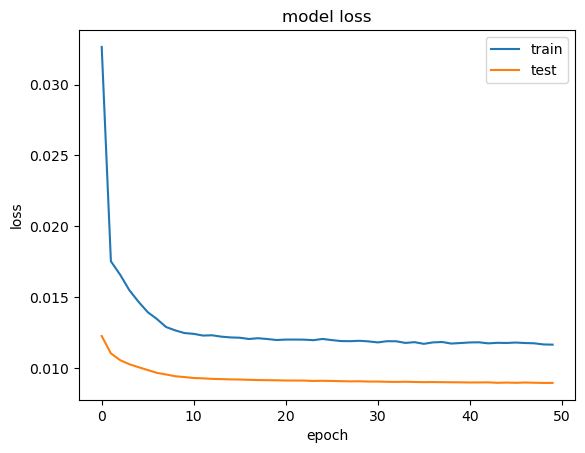

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()


# **Prediction Test**

In [15]:
size = df_resample.shape[1]
yhat = model.predict(test_x)
test_x = test_x.reshape(test_x.shape[0],size)


943/943 [==============================] - 2s 2ms/step


# **Invert Scaling for Prediction**

In [16]:
inv_yhat = np.concatenate((yhat,test_x[:,1-size:]),axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# **Invert scaling for actual**

In [17]:
test_y = test_y.reshape((len(test_y),1))
inv_y = np.concatenate((test_y,test_x[:,1-size:]),axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


# **Calculating RMSE**

In [18]:
rmse = np.sqrt(mean_squared_error(inv_y,inv_yhat))
print('TEST RMSE : %.3f'  %rmse)

TEST RMSE : 0.609


# **Plotting the results**

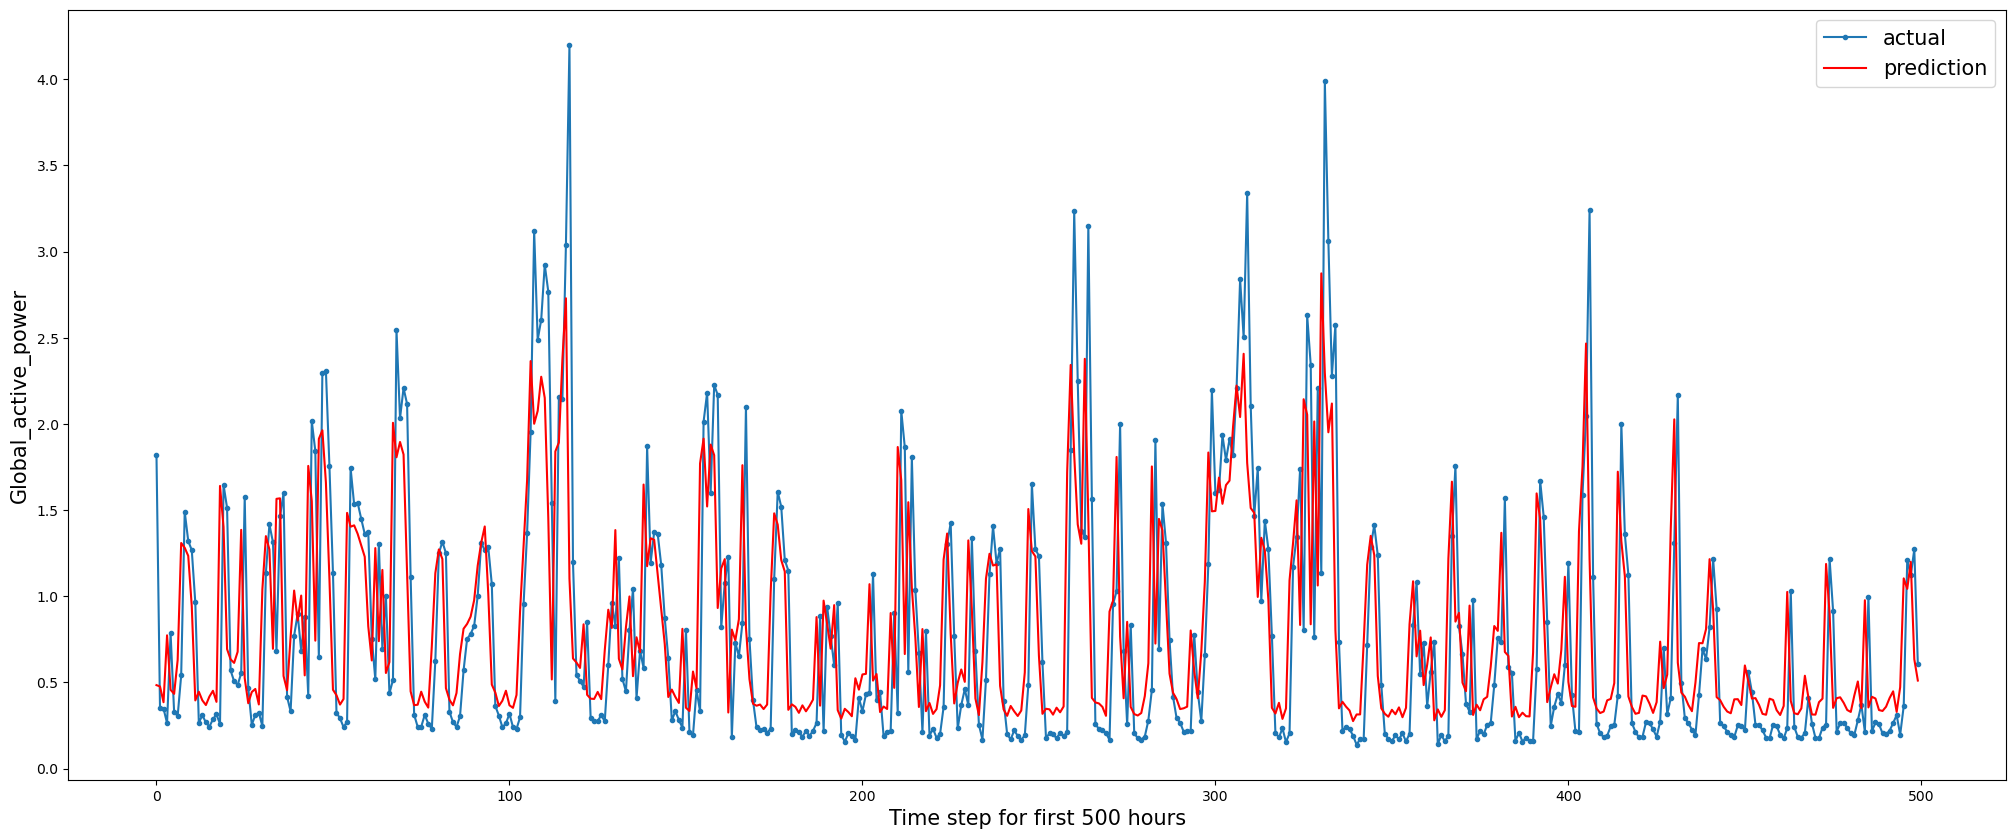

In [19]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()